In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

from sklearn.preprocessing import MinMaxScaler as mms
from tslearn.preprocessing import TimeSeriesScalerMinMax as tmms
from sklearn.cluster import MiniBatchKMeans
from tslearn.clustering import TimeSeriesKMeans

from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from modules.models.autoencoders import VanillaAutoEncoder, RecurrentAutoEncoder, ConvAutoEncoder
from modules.models.clusterers import IDEC
from modules.comparison import compare_clusterers

### Tabular Data - RNA Seq

In [3]:
X = np.load('data\\tabular\\rna_seq\\X.npy', allow_pickle=True).astype('float32')
y = np.load('data\\tabular\\rna_seq\\y.npy', allow_pickle=True).astype('float32')
X = mms().fit_transform(X)
reduction = np.load('results\\umap_reductions\\rna_seq.npy')

In [93]:
vanilla = VanillaAutoEncoder(
    X_shape=X.shape
)

stopper = EarlyStopping(
    monitor='loss',
    min_delta=0.0001,
    patience=10,
    restore_best_weights=True
)
history = vanilla.fit(
    X.astype('float32'), 
    epochs=1000, 
    batch_size=32, 
    callbacks=[stopper],
    verbose=0
)

In [94]:
clusterer_idec = IDEC(
    X=X,
    autoencoder=vanilla,
    n_clusters=5,
    gamma=0.1
)
clusterer_idec.fit(
    X=X,
    epochs=100,
    btch_size=32,
    verbose=False,
    update_interval=10
)

Tol: 0.001 Delta: 0.0
Stop Training


In [95]:
clusterer_kmeans = MiniBatchKMeans(
    n_clusters=5,
    n_init=100,
    max_iter=300
)
clusterer_kmeans.fit(
    X
)

MiniBatchKMeans(max_iter=300, n_clusters=5, n_init=100)

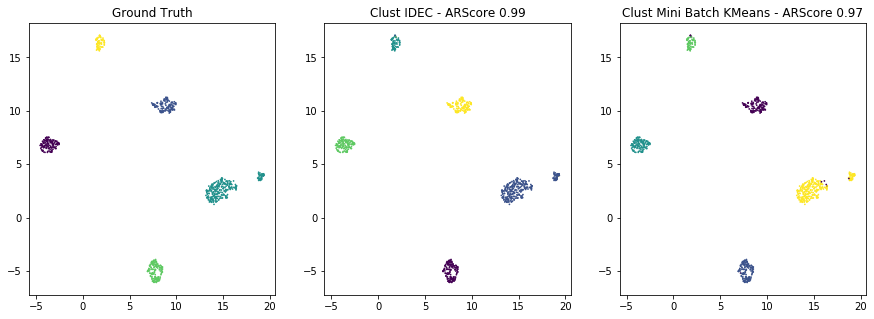

In [7]:
compare_clusterers(
    clusterer_1={'IDEC': clusterer_idec.predict(X).argmax(1).flatten()}, 
    clusterer_2={'Mini Batch KMeans': clusterer_kmeans.labels_}, 
    ground_truth=y, 
    reduction=reduction,
    figsize=(15, 5),
    s=0.5
)

### Time Series Data - NATOPS dataset

In [98]:
X = np.load('data\\time_series\\natops\\X.npy', allow_pickle=True).astype('float32')
y = np.load('data\\time_series\\natops\\y.npy', allow_pickle=True).astype('float32')
X = tmms().fit_transform(X)
reduction = np.load('results\\umap_reductions\\natops.npy')

In [102]:
recurrent = RecurrentAutoEncoder(X_shape=X.shape)

stopper = EarlyStopping(
    monitor='loss',
    min_delta=0.0001,
    patience=10,
    restore_best_weights=True
)
history = recurrent.fit(
    X, 
    epochs=1000, 
    batch_size=32,
    verbose=0
)

In [103]:
clusterer_idec = IDEC(
    X=X,
    autoencoder=recurrent,
    n_clusters=5,
    gamma=0.1
)
clusterer_idec.fit(
    X=X,
    epochs=100,
    btch_size=32,
    verbose=False
)

Tol: 0.001 Delta: 0.0
Stop Training


In [109]:
clusterer_kmeans = TimeSeriesKMeans(
    n_clusters=5, 
    metric='dtw', 
    max_iter=100,
    n_init=5,
    max_iter_barycenter=5
)
clusterer_kmeans.fit(
    X
)

TimeSeriesKMeans(max_iter=100, max_iter_barycenter=5, metric='dtw',
                 n_clusters=5, n_init=5)

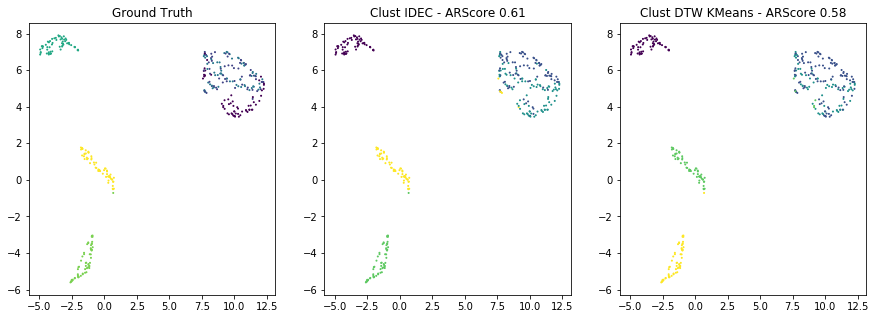

In [110]:
compare_clusterers(
    clusterer_1={'IDEC': clusterer_idec.predict(X).argmax(1).flatten()}, 
    clusterer_2={'DTW KMeans': clusterer_kmeans.labels_}, 
    ground_truth=y.flatten(), 
    reduction=reduction,
    figsize=(15, 5),
    s=1
)

### Images Data - Olivetti

In [4]:
X = np.load('data\\images\\olivetti\\X.npy').reshape((-1, 64, 64, 1))
y = np.load('data\\images\\olivetti\\y.npy', allow_pickle=True).astype('float32')
reduction = np.load('results\\umap_reductions\\olivetti.npy')

In [5]:
convol = ConvAutoEncoder(X_shape=X.shape)

stopper = EarlyStopping(
    monitor='loss',
    min_delta=0.00001,
    patience=20,
    restore_best_weights=True
)
history = convol.fit(
    X,
    noise=0.01,
    epochs=1000, 
    batch_size=64,
    callbacks=[stopper],
    verbose=0
)

In [6]:
clusterer_idec = IDEC(
    X=X,
    autoencoder=convol,
    n_clusters=40,
    gamma=0.5,
    labels=y
)
clusterer_idec.fit(
    X=X,
    epochs=1000,
    btch_size=64,
    update_interval=20,
    verbose=False
)

In [7]:
clusterer_kmeans = MiniBatchKMeans(
    n_clusters=40,
    n_init=100,
    max_iter=300
)
clusterer_kmeans.fit(
    X.reshape(X.shape[0], -1)
)

MiniBatchKMeans(max_iter=300, n_clusters=40, n_init=100)

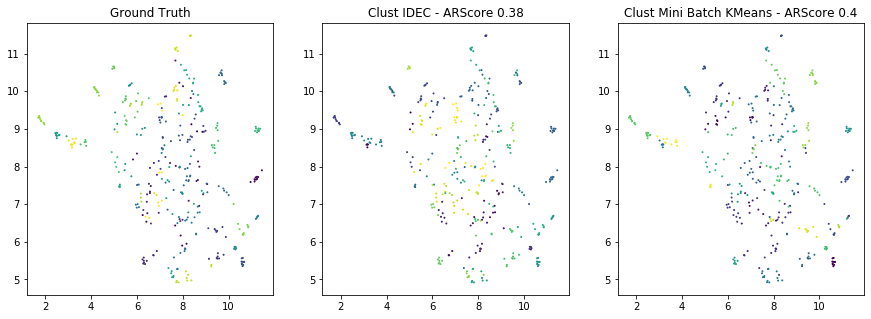

In [8]:
compare_clusterers(
    clusterer_1={'IDEC': clusterer_idec.predict(X).argmax(1).flatten()}, 
    clusterer_2={'Mini Batch KMeans': clusterer_kmeans.labels_}, 
    ground_truth=y, 
    reduction=reduction,
    figsize=(15, 5),
    s=1
)